# Optimizacija hiperparametrov

In [1]:
%run __A_knjiznice.py

# Import specific elements from the script
from __A_knjiznice import *
from __B_funkcije import *
%matplotlib inline

/Users/samonose/PycharmProjects/IDO_inhibitors_ML_predictions/dir1
/Users/samonose/PycharmProjects/IDO_inhibitors_ML_predictions/dir1


In [2]:
input_directory = '/Users/samonose/PycharmProjects/IDO_inhibitors_ML_predictions/dir1/molekulski_prstni_odtisi'

filename = 'df_circular.csv'

In [3]:
import os
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np


file_path = os.path.join(input_directory, filename)
df = pd.read_csv(file_path)
y = df[['Activity']].values.ravel()  # Assuming 'Activity' is the target
X = df.iloc[:, 3:]  # Assuming features start from the 4th column

# Split the data into train and test sets (you can use your existing splits)
X_interim, X_test, y_interim, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_interim, y_interim, test_size=15/85, random_state=42, shuffle=True, stratify=y_interim)

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    # Initialize the Random Forest classifier with suggested hyperparameters
    classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )

    # Stratified k-fold cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scoring = 'accuracy'  # You can change this to other metrics if needed

    # Perform cross-validation
    scores = cross_validate(classifier, X_train, y_train, cv=cv, scoring=scoring)
    
    # Return the mean accuracy
    return scores['test_score'].mean()

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')  # We want to maximize accuracy
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Evaluate the best model
best_params = study.best_params
best_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
best_model.fit(X_train, y_train)

# Validate the model
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Test the model
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

[I 2024-12-01 18:57:56,796] A new study created in memory with name: no-name-46a88aef-c6c0-44de-8b67-92bed5fad3de
[I 2024-12-01 18:57:58,690] Trial 0 finished with value: 0.8578321719969031 and parameters: {'n_estimators': 468, 'max_depth': 92, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.8578321719969031.
[I 2024-12-01 18:57:59,763] Trial 1 finished with value: 0.8599023286284317 and parameters: {'n_estimators': 376, 'max_depth': 69, 'min_samples_split': 11, 'min_samples_leaf': 11, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.8599023286284317.
[I 2024-12-01 18:58:00,873] Trial 2 finished with value: 0.8429962479899947 and parameters: {'n_estimators': 290, 'max_depth': 57, 'min_samples_split': 18, 'min_samples_leaf': 19, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.8599023286284317.
[I 2024-12-01 18:58:01,638] Trial 3 finished with value: 0.883020070275

Best hyperparameters:  {'n_estimators': 475, 'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}
Validation Accuracy: 0.8714
Test Accuracy: 0.8778


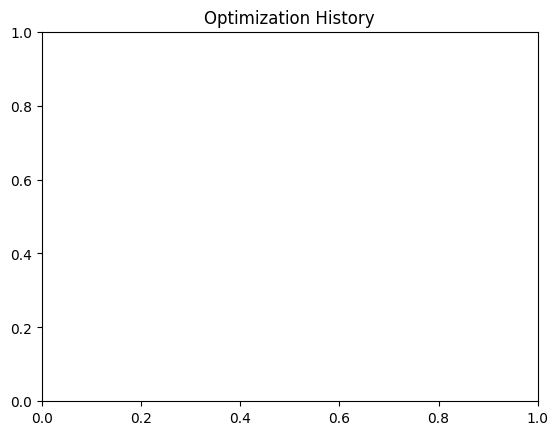

In [5]:
# Plot the optimization history
optuna.visualization.plot_optimization_history(study)
plt.title("Optimization History")
plt.show()


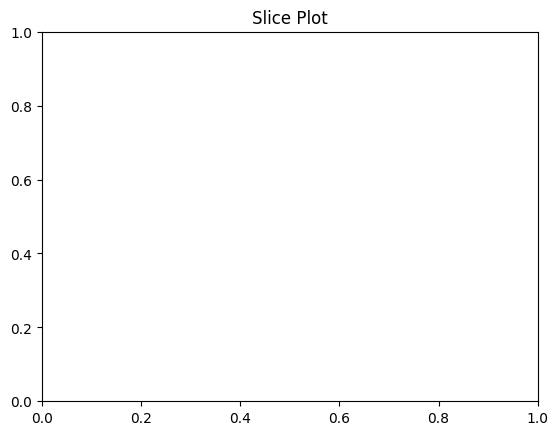

In [6]:
# Plot slice plot for two hyperparameters
optuna.visualization.plot_slice(study)
plt.title("Slice Plot")
plt.show()


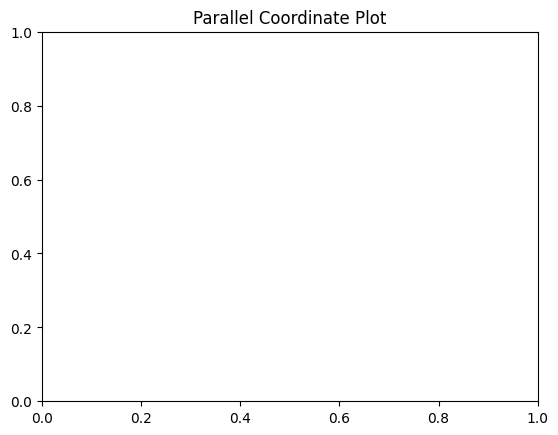

In [7]:
# Plot parallel coordinate plot
optuna.visualization.plot_parallel_coordinate(study)
plt.title("Parallel Coordinate Plot")
plt.show()


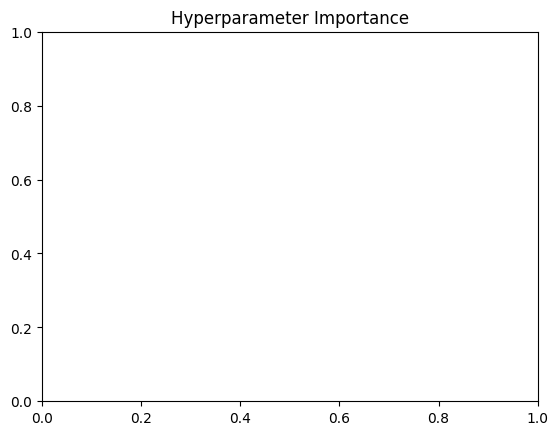

In [8]:
# Plot hyperparameter importance
optuna.visualization.plot_param_importances(study)
plt.title("Hyperparameter Importance")
plt.show()


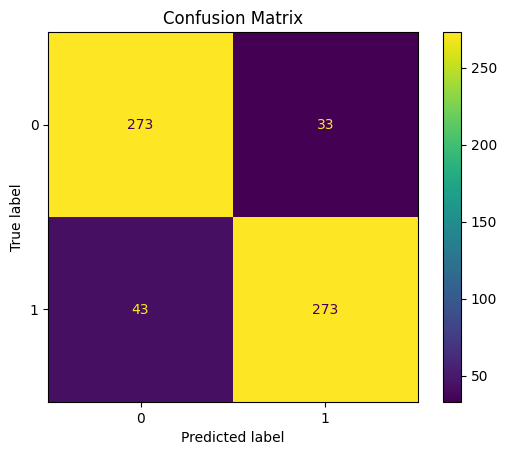

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()


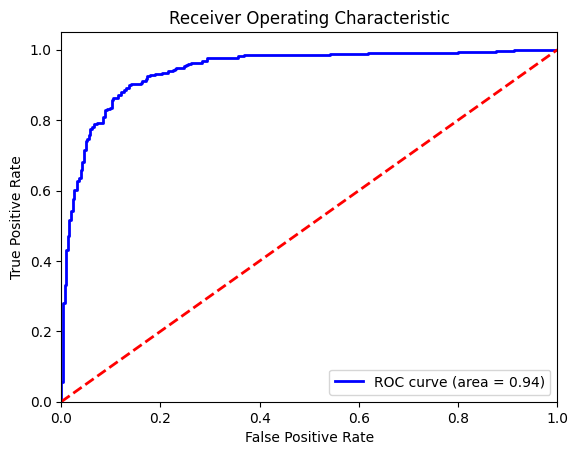

In [10]:
from sklearn.metrics import roc_curve, auc

# Assuming binary classification
y_test_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='green')
plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()


In [ ]:
# Get feature importances
importances = best_model.feature_importances_
feature_names = X.columns  # Assuming X is a DataFrame

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Limit to top N features for better readability
top_n = 10  # Change this value to display more or fewer features
top_features = feature_importance_df.head(top_n)

# Plot feature importances
plt.figure(figsize=(12, 8))  # Increase figure size
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.grid(axis='x')  # Add grid lines for better readability
plt.show()